In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [138]:
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats

from bgspy.utils import load_pickle, mean_ratio, read_bedcov
from bgspy.recmap import RecMap
from bgspy.utils import load_seqlens
from bgspy.nonparametric import Lowess

## Revisions

Since revisions are relatively minor, I am putting them in a separate notebook. 

Files generated with: 

    bedtools makewindows -g hg38_seqlens.tsv -w 1000000 | gzip > windows_1Mb.bed.gz
    bedtools coverage -b cadd_top6_percent.bed.gz -a windows_1Mb.bed.gz | gzip > cadd6_1Mbp.bed.gz

In [15]:
sl = load_seqlens('../data/annotation/hg38_seqlens.tsv')
rm = RecMap('../data/fit_annotation/decode_2019_map.txt', sl)

In [16]:
c6 = load_pickle('../new_fits/cadd6__decode/fits/pop_yri/window_1000000/type_sparse/mutrate_free/initial/mle.pkl')

In [22]:
mp = c6['mbp'].bins.midpoints()
resid = c6['mbp'].resid()

In [76]:
allbins = c6['mbp'].bins

In [63]:
local_recrate = dict()
Mb_recrate = dict()
for chrom in sl:
    if chrom == 'chrX': 
        continue
    local_recrate[chrom] = rm.lookup(chrom, np.array(mp[chrom]))
    
    bins = np.array(c6['mbp'].bins.bins()[chrom])
    start = rm.lookup(chrom, bins[:, 0], cumulative=True)
    end = rm.lookup(chrom, bins[:, 1], cumulative=True)
    width = bins[:, 1] - bins[:, 0]
    Mb_recrate[chrom] = (end-start) /  width

In [64]:
local_recrate.keys()

dict_keys(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22'])

In [65]:
local_recrates = list(itertools.chain(*local_recrate.values()))

In [68]:
Mb_recrates = list(itertools.chain(*Mb_recrate.values()))

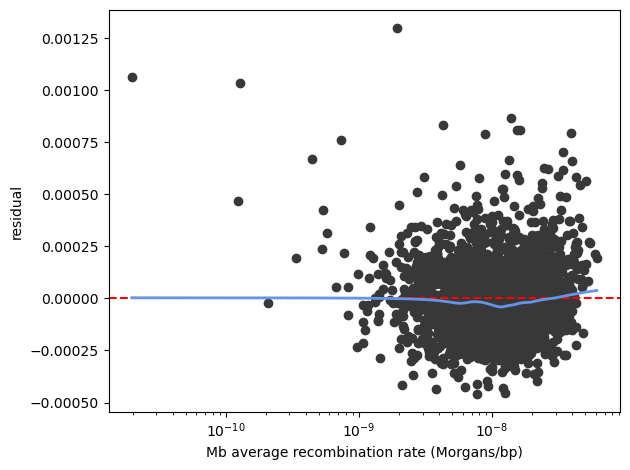

In [127]:
fig, ax = plt.subplots()
ax.scatter(Mb_recrates, resid, c='0.22')
ax.semilogx()
ax.axhline(0, c='r', linestyle='dashed')
lw = Lowess(0.3)
lw.fit(Mb_recrates, resid)
plt.plot(*lw.pairs(),  c='cornflowerblue', linewidth=2)
ax.set_ylabel('residual')
ax.set_xlabel('Mb average recombination rate (Morgans/bp)')

plt.tight_layout()

In [194]:
cov = read_bedcov('../data/fit_annotation/cadd6_1Mbp.bed.gz')
#cov.set_index(['chrom', 'start', 'end'])

In [195]:
cov.head()

,chrom,start,end,nfeature,nbases,length_a,frac
0,chr1,0,1000000,10023,34068,1000000,0.034068
1,chr1,1000000,2000000,17955,69224,1000000,0.069224
2,chr1,2000000,3000000,9186,41676,1000000,0.041676
3,chr1,3000000,4000000,12191,56600,1000000,0.056600
4,chr1,4000000,5000000,7089,31176,1000000,0.031176


In [196]:
d = pd.DataFrame(allbins.flat_bins(), columns=('chrom', 'start', 'end'))
d['resid'] = resid
d.set_index(['chrom', 'start', 'end'])
d.head()

,chrom,start,end,resid
0,chr1,1000000,2000000,0.000195
1,chr1,2000000,3000000,-0.000016
2,chr1,3000000,4000000,0.000139
3,chr1,4000000,5000000,0.000205
4,chr1,5000000,6000000,0.000149


In [207]:
d['start'] = d['start'].astype('int64')
d['end'] = d['end'].astype('int64')
merged_df = pd.merge(d, cov, on=['chrom', 'start', 'end'], how='inner')
merged_df['perc'] = merged_df['frac'] * 100

Text(0.5, 0, 'percent 1Mb window CADD 6%')

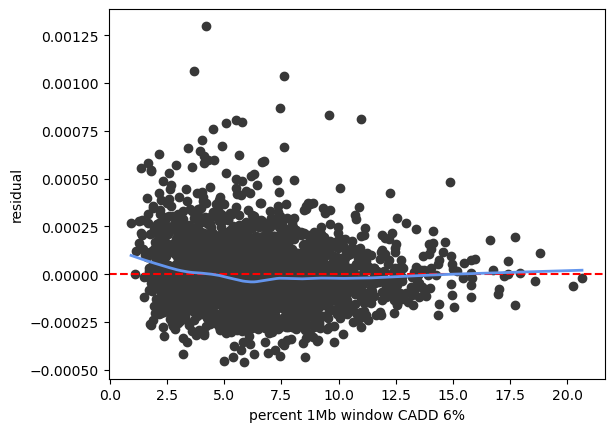

In [210]:
fig, ax = plt.subplots()
ax.scatter(merged_df['perc'], merged_df['resid'], c='0.22')
#ax.semilogx()
ax.axhline(0, c='r', linestyle='dashed')
lw = Lowess(0.3)
lw.fit(merged_df['perc'], merged_df['resid'])
plt.plot(*lw.pairs(),  c='cornflowerblue', linewidth=2)
ax.set_ylabel('residual')
ax.set_xlabel('percent 1Mb window CADD 6%')

Let's look now at these high outliers.

In [ ]:
d.iloc[(resid > 0.001)]

,0,1,2
120,chr1,148000000,149000000
1000,chr6,29000000,30000000
1434,chr9,63000000,64000000


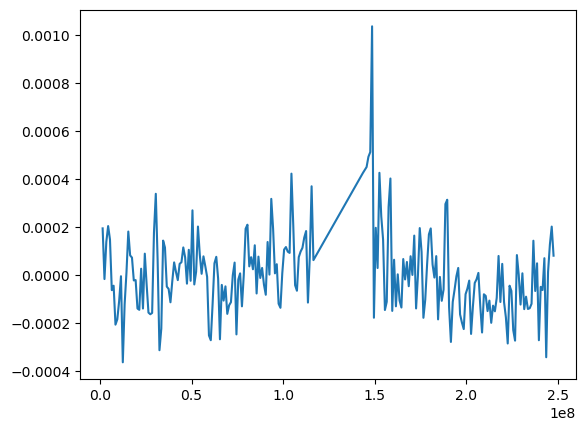

In [ ]:
plt.plot(allbins.midpoints()['chr1'], c6['mbp'].resid()[allbins.chrom_indices('chr1')])

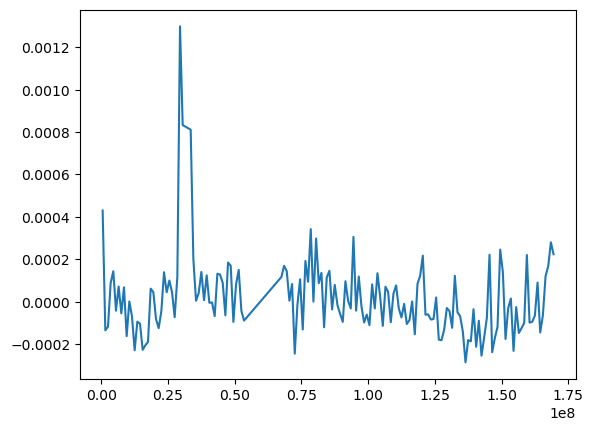

In [98]:
plt.plot(allbins.midpoints()['chr6'], c6['mbp'].resid()[allbins.chrom_indices('chr6')])

Positive residuals = observation > prediction, e.g. excess of $\pi$ compared to prediction. This is MHC. 

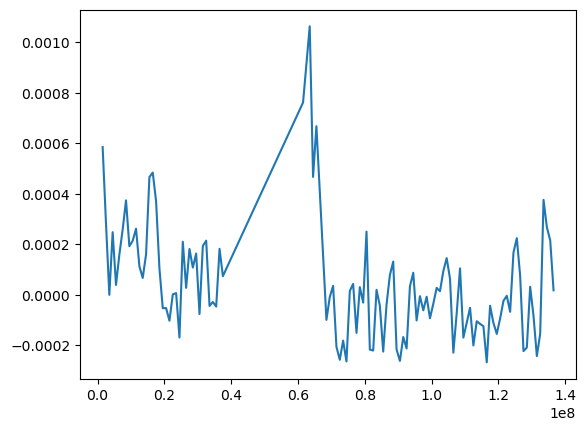

In [99]:
plt.plot(allbins.midpoints()['chr9'], c6['mbp'].resid()[allbins.chrom_indices('chr9')])

So most look centromere-related. 